In [1]:
import os
import csv
import cv2
import torch
import random
import pandas as pd
import numpy as np
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets

In [ ]:
a = np.array([0,128,255],dtype = np.uint8)
print(a)
print(a[0])

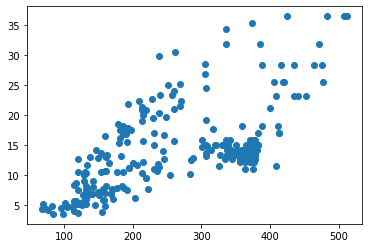

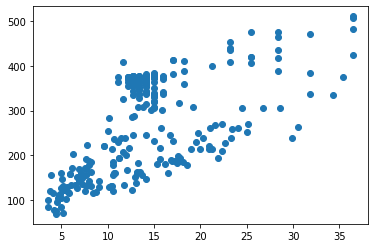

In [122]:
csv_data = pd.read_csv("../output/KOC_bp.csv")
data = csv_data[["file_name","min","max","mean","norm_mean","label"]].iloc[:,:].values

nmd = csv_data[["norm_mean","mean"]].iloc[:,:].values

mm = []
nm = []
ds = []
for item in data:
    mm.append(item[2]/item[1])
    nm.append(item[3]/item[4])
    ds.append([item[2]/item[1],item[3]/item[4]])

dsdf = pd.DataFrame(ds,columns=["a","b"])

plt.plot(nm,mm,"o")
plt.show()
plt.plot(dsdf["a"],dsdf["b"],"o")
plt.show()

3
0


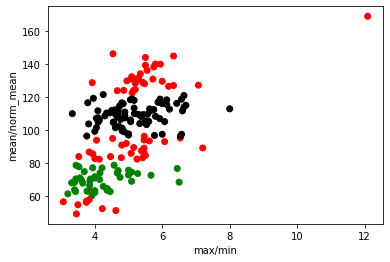

In [259]:
from sklearn.cluster import OPTICS

algorithm = OPTICS(xi=0.05,min_samples=25,min_cluster_size=.05)

algorithm.fit(dsdf)
labels = algorithm.labels_ + 1 
print(max(labels)+1)
print(min(labels))
dsdf["label"] = labels

colors = np.array(["red","green","black","orange","purple","cyan","beige","magenta"])

plt.scatter(dsdf["a"],dsdf["b"],color = colors[dsdf["label"]])

plt.xlabel("max/min")
plt.ylabel("mean/norm_mean")
plt.savefig("../output/savefig/okmmnm.png")
plt.show()

In [15]:
load = "../output/minmax_96x96_mix/mix_bp"
path = "/home/lin/pyProject/pipe-roughness/90/mix/cut/bp"
save = "../output/minmax_96x96_mix/mix_bp_96x96"
for d in os.listdir(load):
    for f in os.listdir("%s/%s" %(load,d)):
        img = plt.imread("%s/%s" %(path,f))
        rimg = cv2.resize(img,(96,96),interpolation=cv2.INTER_AREA)
        cv2.imwrite("%s/%s/%s" %(save,d,f),rimg)

In [9]:
o_value = pd.read_csv("../input_tensor/mix_bp_value.csv")[["file_name","min","max","mean"]].iloc[:,:].values
data = []
for item in o_value:
    print(item)
    data.append([item[0],item[1],item[2]])
    data.append(item[3])
    print(data)
    break

['NG_2019-11-15_15-03-41-1230.bmp' 19 108 45.4168405693829]
[['NG_2019-11-15_15-03-41-1230.bmp', 19, 108], 45.4168405693829]


In [16]:
with open("../output/KOC_gp.csv","w") as csv_file:
    o_label = pd.read_csv("../output/OPTICS_gp_mix.csv")[["file_name","min"]].iloc[:,:].values
    k_label = pd.read_csv("../output/minmax_96x96_mix/KMeans_gp.csv")[["file_name","label"]].iloc[:,:].values
    o_value = pd.read_csv("../input_tensor/mix_gp_value.csv")[["file_name","min","max","mean"]].iloc[:,:].values
    n_value = pd.read_csv("../output/minmax_96x96_mix/gp_value.csv")[["file_name","mean"]].iloc[:,:].values

    writer = csv.writer(csv_file)
    writer.writerow(["file_name","min","max","mean","norm_mean","label"])

    for i,item in enumerate(o_value):
        data = []
        for j in range(4):
            data.append(item[j])
        if n_value[i,0] == item[0]:
            data.append(n_value[i,1])
        else:
            data.append("error")
        
        if o_label[i,0] == item[0] and k_label[i,0] == item[0]:
            data.append((o_label[i,1],k_label[i,1]))
        else:
            data.append("error")

        writer.writerow(data)


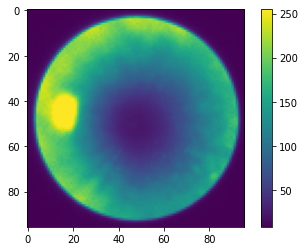

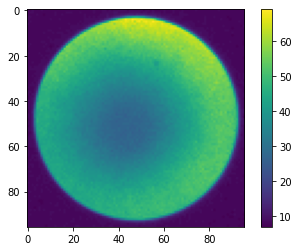

In [2]:
loadPath_bp = "../output/cluster_results/mix_bp/2/NG_b157_2021-07-05_16-04-19-8920.bmp"
# loadPath_bp = "../output/cluster_results/mix_gp/0/68+2019-11-13_11-21-52-4840.bmp"
loadPath_gp = "../output/cluster_results/mix_gp/0/2019-11-14_10-34-38-8520.bmp"

# imgs = os.listdir(loadPath)

img_bp = cv2.resize(plt.imread(loadPath_bp),(96,96),interpolation=cv2.INTER_AREA)
# img = cv2.imread(loadPath,cv2.IMREAD_GRAYSCALE)

th_bp = cv2.adaptiveThreshold(img_bp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)
kernel = np.ones((3,3),dtype=np.uint8)
mx_bp = cv2.morphologyEx(th_bp,op=cv2.MORPH_CLOSE,kernel=kernel)
plt.imshow(img_bp)
plt.colorbar()
plt.show()

# print(np.argwhere(img_bp==np.max(img_bp)))

img_gp = cv2.resize(plt.imread(loadPath_gp),(96,96),interpolation=cv2.INTER_AREA)
th_gp = cv2.adaptiveThreshold(img_gp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)

# img_gp = np.copy(img_bp) 
# img_gp[75:85,50:60] = 0
plt.imshow(img_gp)
plt.colorbar()
plt.show()

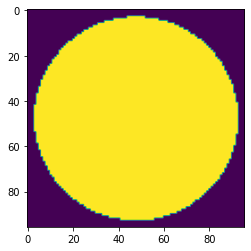

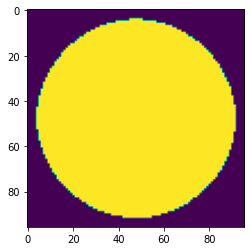

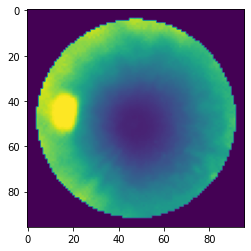

In [8]:
pipeMask = plt.imread("../pipeMask.bmp")/255.
plt.imshow(pipeMask)
plt.show()
kernel = np.ones((3,3),dtype=np.uint8)
pipeMask = cv2.morphologyEx(pipeMask,op=cv2.MORPH_ERODE ,kernel=kernel)
plt.imshow(pipeMask)
plt.show()
plt.imshow(pipeMask*img_bp)
plt.show()

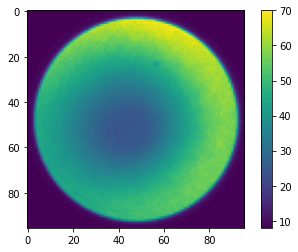

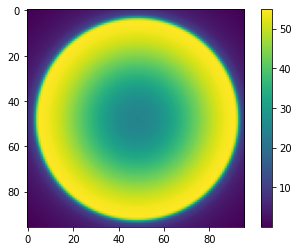

In [80]:
fineBase = plt.imread("../fineBase_gp0.bmp")
plt.imshow(fineBase)
plt.colorbar()
plt.show()

result = np.zeros((96,96),dtype=np.float32)
for angle in range(360):
    mat = cv2.getRotationMatrix2D((48,48),angle,1)
    result += cv2.warpAffine(fineBase,mat,(96,96))

result = result/360.

plt.imshow(result)
plt.colorbar()
plt.show()

In [41]:
cv2.imwrite("../fineBase_gp0_r.bmp",result)

True

In [71]:
def paramf(image):
    density = []

    for x,y in np.argwhere(image!=0):
        density.append(image[x,y])
    
    mins = np.min(density)
    maxs = np.max(density)
    means = np.mean(density)

    std = 0
    for item in density:
        std += (item-means)**2
    
    std /= len(density)

    return mins,maxs,means,std

In [81]:
def base(image):
    output = np.zeros((96,96),dtype=np.float32)
    for angle in range(360):
        mat = cv2.getRotationMatrix2D((48,48),angle,1)
        output += cv2.warpAffine(image,mat,(96,96))

    output = output/360.

    return output

In [72]:

mins,maxs,means,std = paramf(m2)

print(mins,maxs,means,std)

0.3926456868648529 0.7571815848350525 0.5621853940702675 0.005240082844123651


In [93]:
img_load_path = "../output/cluster_results/mix_bp_96x96"
img_save_path = "../output/cluster_results/fft/sperate_mask_0128"
back_save_path = "../output/cluster_results/fft/sperate_mask_0128/background"
param_csv_save = "../output/cluster_results/fft/sperate_mask_0128/param_bp.csv"

with open(param_csv_save,"w") as csv_file:

    writer = csv.writer(csv_file)
    writer.writerow(["file_name","label","min","max","mean","std"])

    for d in os.listdir(img_load_path):
        for fn in os.listdir("%s/%s" %(img_load_path,d)):
            image = plt.imread("%s/%s/%s" %(img_load_path,d,fn))

            result = base(image)

            m1 = image/result
            m2 = pipeMask*m1

            mins,maxs,means,std = paramf(m2) 

            # for x,y in np.argwhere(m2==0):
            #     m2[x,y] = mins

            # gap = 1-mins
            
            # m2 = m2 + gap

            # back = image/m2

            # for x,y in np.argwhere(pipeMask==0):
            #     back[x,y] = 0

            # cv2.imwrite("%s/bp%s/%s" %(back_save_path,d,fn),back)

            # mins,maxs,means,std = paramf(m2)

            writer.writerow([fn,d,mins,maxs,means,std])

            plt.imshow(m2)
            plt.colorbar()
            plt.savefig("%s/bp%s/%s.png" %(img_save_path,d,fn[:-4]))
            plt.close()


In [106]:
img_load_path = "../output/cluster_results/mix_gp_96x96"
mask_load_path = "../output/cluster_results/fft/sperate_mask_0126"
img_save_path = "../output/cluster_results/fft/sperate_mask_0126/cluster"

datas = pd.read_csv("../output/cluster_results/fft/sperate_mask_0126/param_cluster_gp.csv")
ds = datas[["file_name","label","cluster_label"]].iloc[:,:].values

for item in ds:
    image = plt.imread("%s/%s/%s" %(img_load_path,item[1],item[0]))
    mask = plt.imread("%s/gp%s/%s.png" %(mask_load_path,item[1],item[0][:-4]))
    
    cv2.imwrite("%s/image/gp/%s/%s" %(img_save_path,item[2],item[0]),image)
    plt.imsave("%s/mask/gp/%s/%s.png" %(img_save_path,item[2],item[0][:-4]),mask)

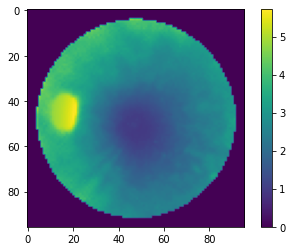

In [68]:
r = result
m1 = img_bp/r
m2 = pipeMask*m1

plt.imshow(m2)
plt.colorbar()
plt.show()

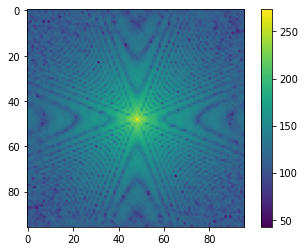

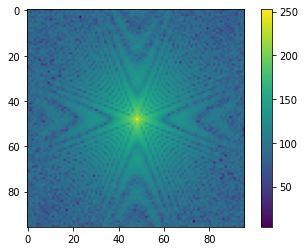

In [376]:
f_bp = np.fft.fft2(img_bp)
fshift_bp = np.fft.fftshift(f_bp)
magnitude_spectrum_bp = 20*np.log(np.abs(fshift_bp))
plt.imshow(magnitude_spectrum_bp)
plt.colorbar()
# plt.savefig("../output/savefig/fft_ng%spng" %loadPath_bp[-8:-3])
plt.show()

# magnitude_spectrum_bp = 20*np.log(np.abs(f_bp))
# plt.imshow(magnitude_spectrum_bp)
# plt.colorbar()
# # plt.savefig("../output/savefig/fft_ok%spng" %loadPath_gp[-8:-3])
# plt.show()

f_gp = np.fft.fft2(img_gp)
fshift_gp = np.fft.fftshift(f_gp)
magnitude_spectrum_gp = 20*np.log(np.abs(fshift_gp))
plt.imshow(magnitude_spectrum_gp)
plt.colorbar()
# plt.savefig("../output/savefig/fft_ok%spng" %loadPath_gp[-8:-3])
plt.show()

# magnitude_spectrum_gp = 20*np.log(np.abs(f_gp))
# plt.imshow(magnitude_spectrum_gp)
# plt.colorbar()
# # plt.savefig("../output/savefig/fft_ok%spng" %loadPath_gp[-8:-3])
# plt.show()

In [115]:
bs = magnitude_spectrum_bp-magnitude_spectrum_gp
for x,y in np.argwhere(bs<0):
    fshift_bp[x,y] = -10

In [277]:
def linear(size,a,b):
    c = size/2
    f_mat_0 = np.zeros((size,size),dtype=float)
    f_mat_1 = np.ones((size,size),dtype=float)

    k = np.tan([a,b])
    for x,y in np.argwhere(f_mat_0==0):
        if (y-c) > k[0]*(x-c) and (y-c) < k[1]*(x-c):
            f_mat_0[x,y] = 1.
            f_mat_0[-x,-y] = 1.
            f_mat_1[x,y] = 0.
            f_mat_1[-x,-y] = 0.
    
    return f_mat_0,f_mat_1

In [10]:
def circle(size,r2,r1=0):
    f_mat_1 = np.ones((size,size),dtype=float)
    f_mat_0 = np.zeros((size,size),dtype=float)

    c = size/2.

    for x,y in np.argwhere(f_mat_1==1):
        if (c-x)**2+(c-y)**2 < r2**2 and (c-x)**2+(c-y)**2 > r1**2:
        # if (48-x)**2+(48-y)**2 > 2**2:
            # if x>40 and x<56:
                f_mat_0[x,y]=1.
                f_mat_1[x,y]=0.
                # fshift[x,y] = 0
    
    return f_mat_0,f_mat_1

In [9]:
def value(size,fshift,a,b=0):
    f_mat_1 = np.ones((size,size),dtype=float)
    f_mat_0 = np.zeros((size,size),dtype=float)

    c = size/2.
    for x,y in np.argwhere(fshift>=b):
        # if fshift[x,y] <= a:
            f_mat_0[x,y] = 1.
            f_mat_1[x,y] = 0.
    
    return f_mat_0,f_mat_1

In [8]:
def matchBord(size):
    f_mat_1 = np.ones((size,size),dtype=float)
    f_mat_0 = np.zeros((size,size),dtype=float)

    flag = True
    for x in range(size):
        for y in range(size):
            if flag:
                f_mat_0[x,y] = 1.
                f_mat_1[x,y] = 0.
            flag = not flag
        flag = not flag
        
    return f_mat_0,f_mat_1

In [7]:
def circle2(size):
    f_mat_1 = np.ones((size,size),dtype=float)
    f_mat_0 = np.zeros((size,size),dtype=float)

    c = size/2.

    for x,y in np.argwhere(f_mat_1==1):
        if ((c-x)**2+(c-y)**2)%2:
        # if (48-x)**2+(48-y)**2 > 2**2:
            # if x>40 and x<56:
                f_mat_0[x,y]=1.
                f_mat_1[x,y]=0.
                # fshift[x,y] = 0
    
    return f_mat_0,f_mat_1

In [197]:
def binr(ms):
    th3 = cv2.adaptiveThreshold(ms,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)
    return th3


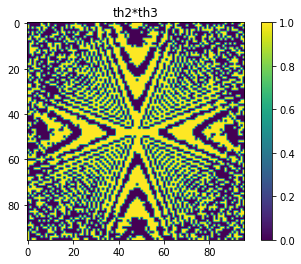

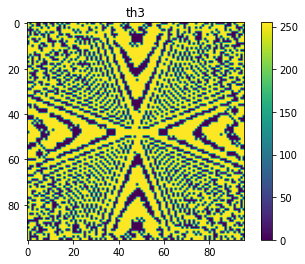

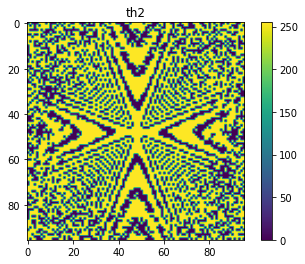

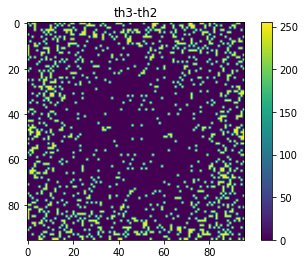

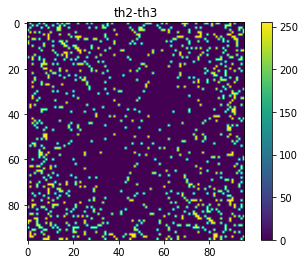

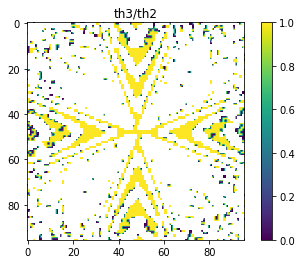

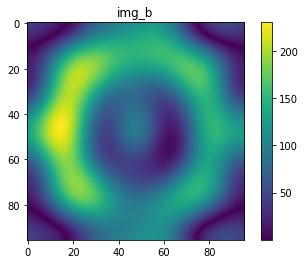

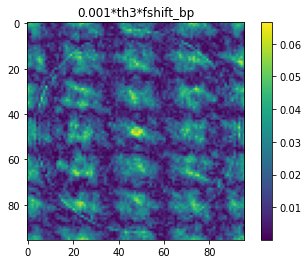

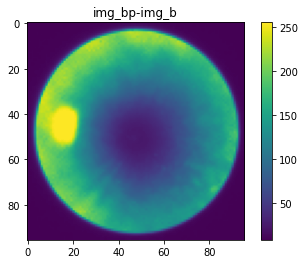

In [368]:
from math import pi

a = 22*pi/180
b = 68*pi/180

# f_mat_0,f_mat_1 = linear(96,a,b)
# f_mat_2,f_mat_3 = linear(96,-a,-b)
f_mat_4,f_mat_5 = circle(96,10)
f_mat_6,f_mat_7 = value(96,magnitude_spectrum_bp,100,b=220)
f_mat_8,f_mat11 = matchBord(96)
f_mat_10,f_mat_11 = circle2(96)

maxv = np.max(magnitude_spectrum_bp)
minv = np.min(magnitude_spectrum_bp)

magnitude_spectrum_bpt = np.ones((96,96),dtype=np.uint8)
for x,y in np.argwhere(magnitude_spectrum_bpt ==1):
    magnitude_spectrum_bpt[x,y] = (255.*(magnitude_spectrum_bp[x,y]-minv)/(maxv-minv))
magnitude_spectrum_gpt = np.ones((96,96),dtype=np.uint8)
for x,y in np.argwhere(magnitude_spectrum_gpt ==1):
    magnitude_spectrum_gpt[x,y] = (255.*(magnitude_spectrum_gp[x,y]-minv)/(maxv-minv))

th2 = binr(magnitude_spectrum_gpt)
th3 = binr(magnitude_spectrum_bpt)

d_mat = np.ones((96,96),dtype=float)
for d in range(3,48,6):
    d0,d1 = circle(96,d,d-3)
    d_mat = d_mat*d1
# plt.imshow(f_mat_6 * magnitude_spectrum_bp)
# plt.title("f_mat_6")
# plt.colorbar()
# plt.show()
plt.imshow(th2*th3)
plt.title("th2*th3")
plt.colorbar()
plt.show()
plt.imshow(th3)
plt.title("th3")
plt.colorbar()
plt.show()
plt.imshow(th2)
plt.title("th2")
plt.colorbar()
plt.show()
plt.imshow(th3-th2)
plt.title("th3-th2")
plt.colorbar()
plt.show()
plt.imshow(th2-th3)
plt.title("th2-th3")
plt.colorbar()
plt.show()
plt.imshow(th2/th3)
plt.title("th3/th2")
plt.colorbar()
plt.show()
# plt.imshow((th2-th3)-(th3-th2))
# plt.title("(th2-th3)-(th3-th2)")
# plt.colorbar()
# plt.show()

f_ishift = np.fft.ifftshift(f_mat_6*fshift_bp)
img_b = np.abs(np.fft.ifft2(f_ishift))
plt.imshow(img_b)
plt.title("img_b")
plt.colorbar()
# plt.savefig("../output/hpok2680.png")
plt.show()
f_ishift = np.fft.ifftshift(0.00001*(th3-th2)*fshift_bp)
img_b = np.abs(np.fft.ifft2(f_ishift))
plt.imshow(img_b)
plt.title("0.001*th3*fshift_bp")
plt.colorbar()
# plt.savefig("../output/hpok2680.png")
plt.show()
plt.imshow(img_bp-img_b)
plt.title("img_bp-img_b")
plt.colorbar()
# plt.savefig("../output/hpok2680.png")
plt.show()

78.9358428030303


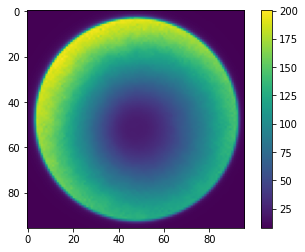

In [471]:
fineBase = np.zeros((96,96),dtype=float)

path = "../output/cluster_results/mix_bp/2"
for item in os.listdir(path):
    img = cv2.resize(plt.imread("%s/%s" %(path,item)),(96,96),interpolation=cv2.INTER_AREA)
    fineBase = fineBase + img

fineBase /= len(os.listdir(path))

baseMean = np.mean(fineBase)
print(baseMean)
plt.imshow(fineBase)
plt.colorbar()
plt.show()

# cv2.imwrite("../fineBase.bmp",fineBase)

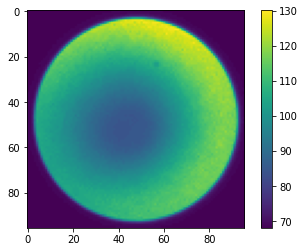

In [480]:
fineBase = plt.imread("../fineBase_gp0.bmp")
baseMean = np.mean(img_bp)
fineBase =fineBase- np.mean(fineBase) +baseMean

plt.imshow(fineBase)
plt.colorbar()
plt.show()
# base = img_gp/fineBase

# minv = np.min(base)
# maxv = np.max(base)

# base += (maxv-minv)
# base 

# th = cv2.adaptiveThreshold(base,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)
# kernel = np.ones((3,3),dtype=np.uint8)

# for x,y in np.argwhere(th>0):
#     if (x-48)**2+(y-48)**2>48**2:
#         th[x,y] = 0
# mo = cv2.morphologyEx(th,op=cv2.MORPH_CLOSE,kernel=kernel)

# plt.imshow(th)
# plt.show()
# plt.imshow(mo)
# plt.show()

# cv2.imwrite("../pipeMask.bmp",mo)

In [ ]:
def pipeArea(size=96,parts=12):
    mat = np.ones((size,size),dtype=float)
    step = 360/12
    k = np.tan([i*pi/180 for i in range(0,180,step)])
    for x,y in np.argwhere(mat!=0):
        if (x-48)**2+(y-48)**2>45**2  :
            mat[x,y] = np.nan
        else:
            mat[x,y] = (y-48)/(x-48)
    
    for x,y in np.argwhere(mat != np.nan):
        (y-48)/(x-48)
    return mean/counter

In [246]:
from math import pi
k = np.tan([i*pi/180 for i in range(0,180,30)])
print(k)

[ 0.00000000e+00  5.77350269e-01  1.73205081e+00  1.63312394e+16
 -1.73205081e+00 -5.77350269e-01]


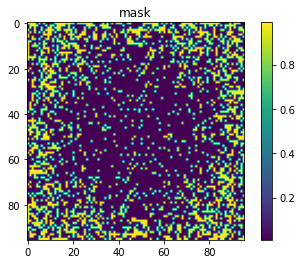

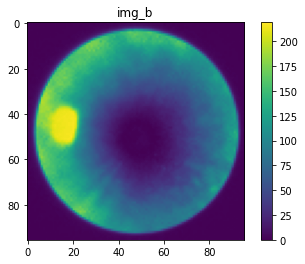

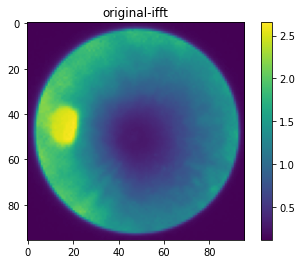

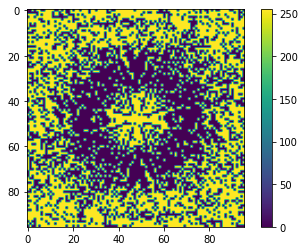

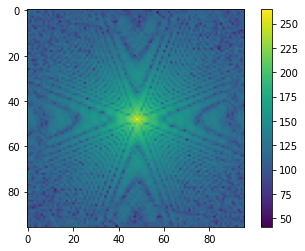

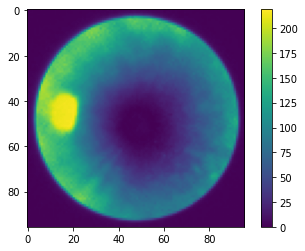

In [481]:
mask = 0.99*np.ones((96,96),dtype=float)

for x,y in np.argwhere((th3-th2)<=0):
    mask[x,y] = 0.01

plt.imshow(mask)
plt.title("mask")
plt.colorbar()
plt.show()

f_ishift = np.fft.ifftshift(fshift_bp-fshift_gp)
img_b = np.abs(np.fft.ifft2(f_ishift))
plt.imshow(img_b)
plt.title("img_b")
plt.colorbar()
plt.show()

plt.imshow(img_bp/fineBase)
plt.title("original-ifft")
plt.colorbar()
plt.show()

# print((img_bp/fineBase)[55])

fft = np.fft.fft2(img_bp/img_gp)
fs = np.fft.fftshift(fft)
ms = 20*np.log(np.abs(fs))

kernel = np.ones((3,3),dtype=np.uint8)
kernel[0,0] = 0
kernel[0,2] = 0
kernel[2,0] = 0
kernel[2,2] = 0
kernel[1,1] = 0
# mx = cv2.morphologyEx(th_bp,op=cv2.MORPH_CLOSE,kernel=kernel)

# maxv = 60
# minv = 20

mst = np.ones((96,96),dtype=np.uint8)
for x,y in np.argwhere(mst ==1):
    mst[x,y] = (255.*(ms[x,y]-minv)/(maxv-minv))
plt.imshow(binr(mst))
plt.colorbar()
plt.show()

fft = np.fft.fft2(img_bp)-np.fft.fft2(img_gp)
fs = np.fft.fftshift(fft)
ms = 20*np.log(np.abs(fs))
plt.imshow(ms)
plt.colorbar()
plt.show()

plt.imshow(np.abs(np.fft.ifft2(np.fft.ifftshift(fft))))
plt.colorbar()
plt.show()

[149. 160. 146. 165. 161. 155. 142. 141. 151. 157. 170. 169. 180. 183.
 174. 177. 175. 173. 179. 172. 135. 163. 162. 167. 176. 184. 166. 132.
 171. 156. 159. 178. 168. 164. 147. 158. 188. 190. 187. 186. 143. 181.
 192. 189. 153. 150. 185. 195. 182. 152. 148. 139. 193. 154. 144. 191.
 140. 145. 137. 133. 134. 131. 138. 125. 122. 136. 130. 128. 121. 127.
 129. 124. 126. 116. 120. 117. 118. 119. 123. 114. 115. 112. 110. 111.
 109. 194. 107. 108. 113. 106. 104. 196. 197. 105. 103. 201. 200.  99.
 102. 199. 101. 100.  96.  97.  98.  95.  94. 204.  93.  90.  92.  89.
  91.  88. 208. 203.  87.  84.  86. 205. 207. 198.  81.  82.  83.  85.
 217. 202.  80.  78.  79.  77. 216. 213. 211.  75.  73.  72.  71.  76.
 209. 215. 206.  70.  67.  66.  68.  69.  74. 218.  63.  65.  64. 220.
 214.  62.  60.  59.  61. 212.  58.  56.  55.  57. 210. 224. 228. 232.
 233. 226.  53.  54.  52. 219. 241. 242. 246. 248. 235.  51.  50.  49.
  48. 230. 245. 250. 255. 254. 251. 225.  47.  46. 227. 231. 247. 252.
 257. 

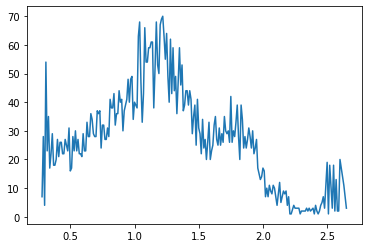

In [493]:
dmask = img_bp/fineBase
value = []
number = []
for x,y in np.argwhere(pipeMask>0):
    v = round(100*dmask[x,y])
    if v not in value:
        value.append(v)
        number.append(1)
    else:
        number[value.index(v)] += 1
value = np.array(value)
number = np.array(number)
print(value,type(value))
print(number)
temp = np.zeros(len(value),dtype=np.uint8)

e = np.copy(value)
e.sort()
print(e)
for item in e:
    temp[np.argwhere(e==item)] = number[np.argwhere(value==item)]

print(np.sum(temp)) 
plt.plot(e/100.,temp)
plt.show()

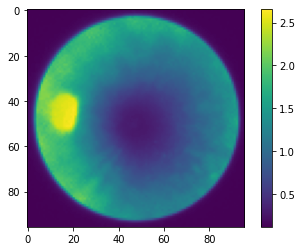

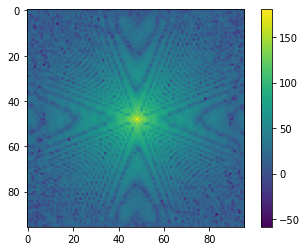

1.621859778278577
0.19874906247585739


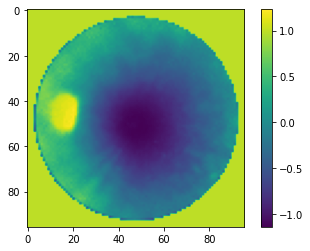

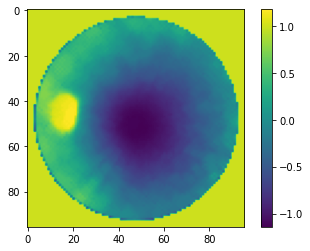

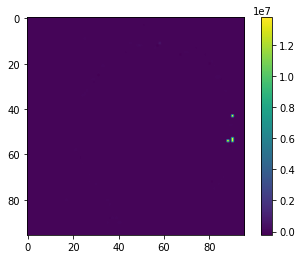

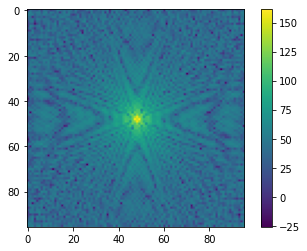

In [484]:
dmask = img_bp/fineBase
pipeMask = plt.imread("../pipeMask.bmp")
plt.imshow(dmask)
plt.colorbar()
plt.show()


dfft = np.fft.fft2(dmask)
fshift = np.fft.fftshift(dfft)
ms = 20*np.log(np.abs(fshift))

plt.imshow(ms)
plt.colorbar()
plt.show()

# print(dmask[70])
mean_inside = 0
counter = 0
for x,y in np.argwhere(dmask>=np.min(dmask)):
    if (x-48)**2+(y-48)**2<44**2 and (x-48)**2+(y-48)**2>40**2:
        mean_inside+=dmask[x,y]
        counter+=1

mean_inside /= counter
print(mean_inside)

mean_outside = 0
counter = 0

for x,y in np.argwhere(pipeMask==0):
    # if (x-48)**2+(y-48)**2 >48**2:
    mean_outside += dmask[x,y]
    counter += 1
mean_outside /= counter
print(mean_outside)

for x,y in np.argwhere(pipeMask>0):
    # if (x-48)**2+(y-48)**2<46**2:
    dmask[x,y] += (mean_outside - mean_inside )
    # else:
for x,y in np.argwhere(pipeMask==0):
    dmask[x,y] = 1

# print(dmask[70])

plt.imshow(dmask)
plt.colorbar()
plt.show()

plt.imshow(cv2.morphologyEx(dmask,op=cv2.MORPH_OPEN,kernel=kernel))
plt.colorbar()
plt.show()

plt.imshow(img_bp/dmask)
plt.colorbar()
plt.show()

dfft = np.fft.fft2(cv2.morphologyEx(dmask,op=cv2.MORPH_OPEN,kernel=kernel))
fshift = np.fft.fftshift(dfft)
ms = 20*np.log(np.abs(fshift))

plt.imshow(ms)
plt.colorbar()
plt.show()

In [485]:
print(len(np.argwhere(pipeMask>0)))

6345


(18432+0j) [[0 0]]


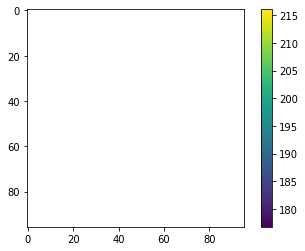

In [104]:
emp = 2*np.ones((96,96),dtype=float)

e_fft = np.fft.fft2(emp)
e_fshift = np.fft.fftshift(e_fft)
magnitude_spectrum = 20*np.log(np.abs(e_fshift))

for j in e_fft:
    for i in j:
        if i.real!=0 or i.imag!=0:
            print(i,np.argwhere(e_fft==i))

plt.imshow(magnitude_spectrum)
plt.colorbar()
plt.show()

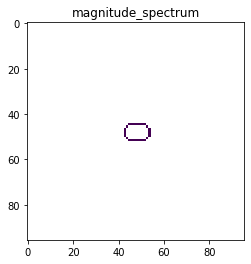

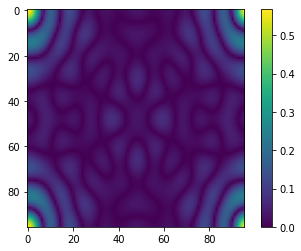

In [133]:
fft = np.zeros((96,96),dtype=np.complex128)
fshift = np.fft.fftshift(fft)

for x in range(96):
    for y in range(96):
        if 49*(x-48)**2 +25*(y-48)**2 <=49*25 and 25*(x-48)**2+9*(y-48)**2>=25*9:
            fshift[x,y] = 77+0j



magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.imshow(magnitude_spectrum)
plt.title("magnitude_spectrum")
plt.show()
# ifshift = np.fft.ifftshift(fshift)
img_b = np.abs(np.fft.ifft2(fshift))
plt.imshow(img_b)
plt.colorbar()
plt.show()

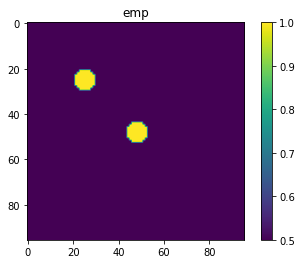

<class 'numpy.complex128'> (-2.5299294256774387-1.4606554349456249j)


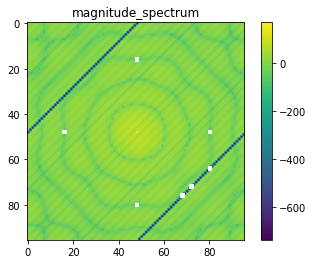

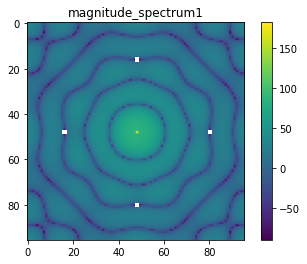

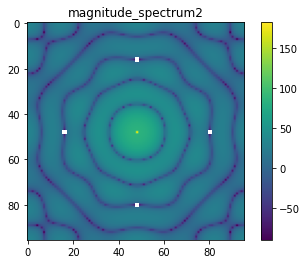

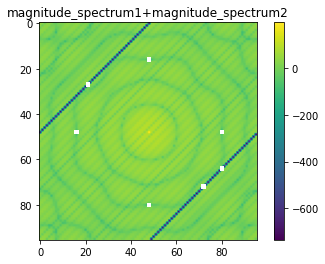

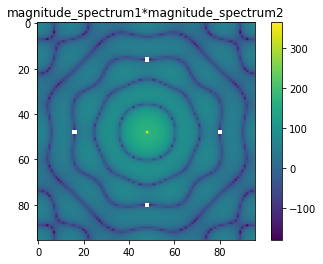

In [313]:
emp = 0.5*np.ones((96,96),dtype=float)
emp1 = np.ones((96,96),dtype=float)
emp2 = np.ones((96,96),dtype=float)
# emp[35:55,35:55] *= 2
# emp[35:40,35:45] *= 0.5
# emp1[35:55,35:55] = 2
# emp2[35:40,35:45] = 0.5
# emp[30,60] = 10

for x,y in np.argwhere(emp!=0):
    if (x-48)**2+(y-48)**2<5**2:
        emp[x,y] *= 2
        emp1[x,y] = 2
    elif (x-25)**2+(y-25)**2<5**2:
        emp[x,y] *= 2
        emp2[x,y] = 2


plt.imshow(emp)
plt.title("emp")
plt.colorbar()
plt.show()

e_fft = np.fft.fft2(emp)
e_fshift = np.fft.fftshift(e_fft)
magnitude_spectrum = 20*np.log(np.abs(e_fshift))
e_fft1 = np.fft.fft2(emp1)
e_fshift1 = np.fft.fftshift(e_fft1)
magnitude_spectrum1 = 20*np.log(np.abs(e_fshift1))
e_fft2 = np.fft.fft2(emp2)
e_fshift2 = np.fft.fftshift(e_fft2)
magnitude_spectrum2 = 20*np.log(np.abs(e_fshift2))

print(type(e_fft[35,45]),e_fft[35,45])

plt.imshow(magnitude_spectrum)
plt.title("magnitude_spectrum")
plt.colorbar()
plt.show()
plt.imshow(magnitude_spectrum1)
plt.title("magnitude_spectrum1")
plt.colorbar()
plt.show()
plt.imshow(magnitude_spectrum2)
plt.title("magnitude_spectrum2")
plt.colorbar()
plt.show()


plt.imshow(20*np.log(np.abs(e_fshift2+e_fshift1)))
plt.title("magnitude_spectrum1+magnitude_spectrum2")
plt.colorbar()
plt.show()
plt.imshow(20*np.log(np.abs(e_fshift2*e_fshift1)))
plt.title("magnitude_spectrum1*magnitude_spectrum2")
plt.colorbar()
plt.show()

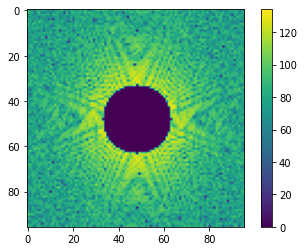

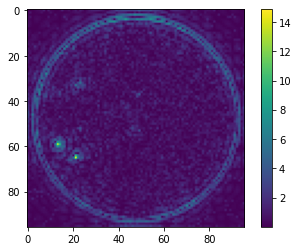

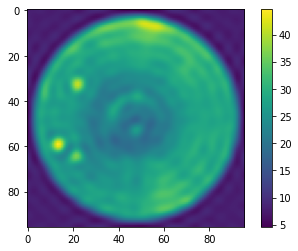

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


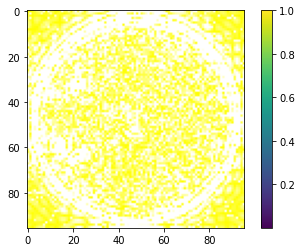

In [443]:
f_mat_1 = np.ones((96,96),dtype=float)
f_mat_0 = np.zeros((96,96),dtype=float)

r = 15

for x,y in np.argwhere(f_mat_1==1):
    # if (48-x)**2+(48-y)**2 < 10**2 and (48-x)**2+(48-y)**2 > 5**2:
    if (48-x)**2+(48-y)**2 > r**2:
        # if x>40 and x<56:
            f_mat_0[x,y]=1.
            f_mat_1[x,y]=0.
            # fshift[x,y] = 0
plt.imshow(f_mat_0*magnitude_spectrum_gp)
plt.colorbar()
plt.savefig("../output/savefig/fftr%dok%s.png" %(r,loadPath_gp[-8:-4]))
plt.show()

# fshift= f_mat_0*fshift
# fshift_gp[45:50,30:60] =0  
f_ishift_0 = np.fft.ifftshift(f_mat_0 * fshift_gp)
f_ishift_1 = np.fft.ifftshift(f_mat_1 * fshift_gp)
img_0 = np.abs(np.fft.ifft2(f_ishift_0))
img_1 = np.abs(np.fft.ifft2(f_ishift_1))
plt.imshow(img_0)
plt.colorbar()
plt.savefig("../output/savefig/hpr%dok%s.png" %(r,loadPath_gp[-8:-4]))
plt.show()
plt.imshow(img_1)
plt.colorbar()

plt.show()
plt.imshow(mix(img_gp,img_1,img_0))
plt.colorbar()
# plt.savefig("../output/hpok2680.png")
plt.show()

In [347]:
def mix(a,b,c):
    img = np.zeros((96,96,3),dtype=float)
    for x in range(96):
        for y in range(96):
            img[x,y,0] = a[x,y]
            img[x,y,1] = b[x,y]
            img[x,y,2] = c[x,y]
    
    return img

In [27]:
# cuda = True if torch.cuda.is_available() else False
# if cuda:
#     Tensor = torch.cuda.FloatTensor
input_tensor = torch.FloatTensor(img).view(1,1,294,294)
print(input_tensor.shape)
print(input_tensor.dtype)

torch.Size([1, 1, 294, 294])
torch.float32


torch.Size([5, 49, 49])


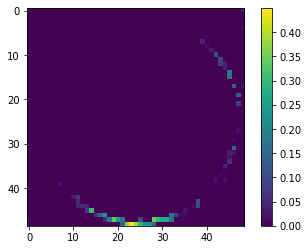

In [164]:
cnp = nn.Sequential(
    nn.Conv2d(1,3,3,padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(inplace=True),

    nn.Conv2d(3,5,3,padding=2),
    nn.MaxPool2d(3),
    nn.ReLU(inplace=True)
)

output = cnp(input_tensor).view(5,49,49)
# print(output)
print(output.shape)

image = output.detach().numpy()
img1 = image[0]
image = np.reshape(image,(49,49,5))

plt.imshow(img1)
plt.colorbar()
plt.show()

# print(img)

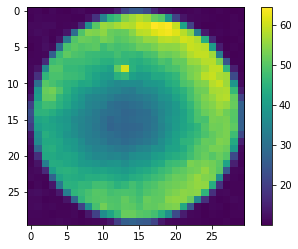

In [12]:
plt.imshow(cv2.resize(img,(30,30),interpolation=cv2.INTER_AREA))
plt.colorbar()
plt.show()

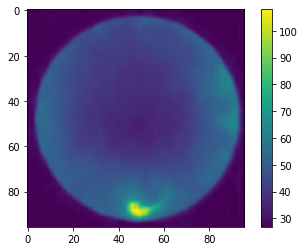

True

In [9]:
min = 20
max = 108
img = img/255.
img = img*(max-min)+min
plt.imshow(img)
plt.colorbar()
plt.show()
cv2.imwrite("../%s_%s.bmp" %(min,max),img)

In [14]:
img = plt.imread("../output/minmax_96x96_mix/mix_bp/1/NG_b157_2021-07-05_16-55-37-4410.bmp")/255.
# cluster_results
with open("../4410_value.csv","w") as csv_file:
    writer = csv.writer(csv_file)

    writer.writerow(["row","col","value"])
    for r_num in range(img.shape[0]):
        for c_num in range(img.shape[1]):
            writer.writerow([r_num,c_num,img[r_num,c_num]])

In [2]:
dataloader = DataLoader(
    torch.load("../input_tensor/gp-1_minmax_96x96_mix.pt"),
    batch_size=1
)
i_num = 0
for item in dataloader:
    item = torch.reshape(item,(96,96))
    # print(item.shape)
    # plt.imshow(item)
    # plt.show()
    # break

    cv2.imwrite("../output/cluster_results/minmax_96x96_mix/gp-1/%d.bmp" %i_num,255.*item.cpu().detach().numpy())
    i_num+=1

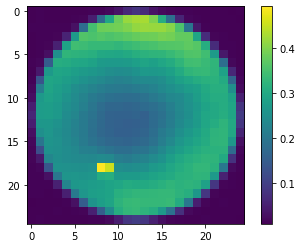

In [26]:
plt.imshow(cv2.resize(plt.imread("../output/minmax_96x96_mix/mix_bp/0/NG_68+2019-11-13_11-03-03-9570.bmp")/255.,(25,25),interpolation=cv2.INTER_AREA))
plt.colorbar()
plt.show()

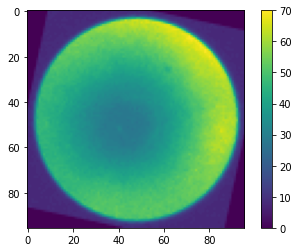

In [217]:
ds = torch.load("../input_tensor/gp0_minmax_96x96_mix_UN_increase.pt")

for item in ds:
    plt.imshow(item)
    plt.colorbar()
    plt.show()
    break

In [24]:
p = []
p.append([])
p[0].append(1)
p.append([])
p[1].append(2)
print(p)
print(p[0])

[[1], [2]]
[1]


In [67]:
# path = "/home/lin/pyProject/pipe-roughness/90/mix/cut/bp"
path = "../output/cluster_results/mix_bp/0"
ilist = os.listdir(path)
print(ilist[:3])

['NG_2019-11-15_15-03-41-1230.bmp', 'NG_b157_2021-07-05_15-54-09-7970.bmp', 'NG_b157_2021-07-05_15-49-57-0350.bmp']


(294, 294)


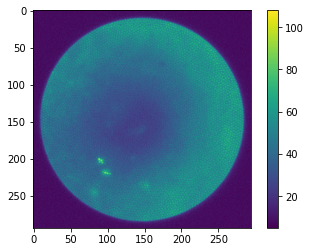

In [75]:
cvimg = plt.imread("../output/cluster_results/mix_bp/0/NG_2019-11-15_15-03-41-1230.bmp")
print(cvimg.shape)
plt.imshow(cvimg)
plt.colorbar()
plt.show()

min:7.000000
max:77.000000


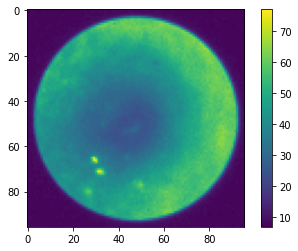

In [76]:
rimg=cv2.resize(cvimg,(96,96),interpolation=cv2.INTER_AREA)
print("min:%f\nmax:%f" %(np.min(rimg),np.max(rimg)))
plt.imshow(rimg)
plt.colorbar()
plt.show()

min:0.000000
max:1.000000


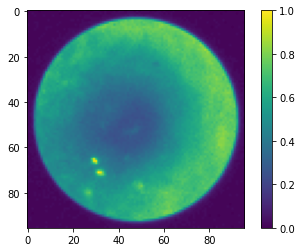

In [77]:
import norm 

nimg = norm.Normalize_circle_minmax(rimg)
print("min:%f\nmax:%f" %(np.min(nimg),np.max(nimg)))
plt.imshow(nimg)
plt.colorbar()
plt.show()

In [19]:
print(cvimg)

[[[ 0  0  0]
  [ 9  9  9]
  [ 2  2  2]
  ...
  [ 8  8  8]
  [ 5  5  5]
  [ 4  4  4]]

 [[ 0  0  0]
  [ 6  6  6]
  [ 9  9  9]
  ...
  [10 10 10]
  [ 2  2  2]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 6  6  6]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [10 10 10]
  [ 9  9  9]]

 ...

 [[ 4  4  4]
  [13 13 13]
  [10 10 10]
  ...
  [29 29 29]
  [32 32 32]
  [ 0  0  0]]

 [[ 5  5  5]
  [ 3  3  3]
  [25 25 25]
  ...
  [49 49 49]
  [41 41 41]
  [ 0  0  0]]

 [[ 0  0  0]
  [13 13 13]
  [ 9  9  9]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 3  3  3]]]


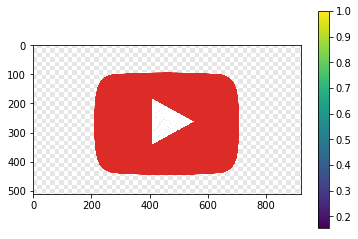

In [20]:
image = plt.imread("../images/pic.png")
plt.imshow(image)
plt.colorbar()
plt.show()

In [21]:
print(image)

[[[1.        1.        1.       ]
  [1.        1.        1.       ]
  [1.        1.        1.       ]
  ...
  [0.9019608 0.9019608 0.9019608]
  [0.9019608 0.9019608 0.9019608]
  [0.9019608 0.9019608 0.9019608]]

 [[1.        1.        1.       ]
  [1.        1.        1.       ]
  [1.        1.        1.       ]
  ...
  [0.9019608 0.9019608 0.9019608]
  [0.9019608 0.9019608 0.9019608]
  [0.9019608 0.9019608 0.9019608]]

 [[1.        1.        1.       ]
  [1.        1.        1.       ]
  [1.        1.        1.       ]
  ...
  [0.9019608 0.9019608 0.9019608]
  [0.9019608 0.9019608 0.9019608]
  [0.9019608 0.9019608 0.9019608]]

 ...

 [[0.9019608 0.9019608 0.9019608]
  [0.9019608 0.9019608 0.9019608]
  [0.9019608 0.9019608 0.9019608]
  ...
  [1.        1.        1.       ]
  [1.        1.        1.       ]
  [1.        1.        1.       ]]

 [[1.        1.        1.       ]
  [1.        1.        1.       ]
  [1.        1.        1.       ]
  ...
  [0.9019608 0.9019608 0.9019608]
  [0

In [27]:
path = "../input_tensor/gp_minmax.pt"
save = "/home/lin/pipe_classifier_by_miTech/05_cnn_v3/dataset_pipe/gan_gen/test_dataset/gp"

dataloader = DataLoader(
    torch.load(path),
    batch_size=1,
    shuffle=False
)
for i,data in enumerate(dataloader):
    plt.imshow(data)
    plt.show()
    break

TypeError: Invalid shape (1, 96, 96) for image data

In [64]:
print(3000//16)
print(3000%16)
print(16*187+8)

187
8
3000


In [21]:
fl = os.listdir("../model_weights/model_21728_bp_minmax")
print(fl)

['generator_21728_2.0.pt', 'generator_21728_33.0.pt', 'generator_21728_26.0.pt', 'generator_21728_28.0.pt', 'generator_21728_17.0.pt', 'generator_21728_40.0.pt', 'generator_21728_19.0.pt', 'generator_21728_3.0.pt', 'generator_21728_7.0.pt', 'generator_21728_5.0.pt', 'generator_21728_21.0.pt', 'generator_21728_23.0.pt', 'generator_21728_8.0.pt', 'generator_21728_31.0.pt', 'generator_21728_10.0.pt', 'generator_21728_12.0.pt', 'generator_21728_13.0.pt', 'generator_21728_35.0.pt', 'generator_21728_20.0.pt', 'generator_21728_41.0.pt', 'generator_21728_14.0.pt', 'generator_21728_29.0.pt', 'generator_21728_34.0.pt', 'generator_21728_42.0.pt', 'generator_21728_36.0.pt', 'generator_21728_9.0.pt', 'generator_21728_32.0.pt', 'generator_21728_1.0.pt', 'generator_21728_39.0.pt', 'generator_21728_6.0.pt', 'generator_21728_25.0.pt', 'generator_21728_24.0.pt', 'generator_21728_16.0.pt', 'generator_21728_27.0.pt', 'generator_21728_4.0.pt', 'generator_21728_0.0.pt', 'generator_21728_22.0.pt', 'generator

In [62]:
date = "21728"
fnl = []
for item in fl:
    temp = item[item.index(date[len(date)-1])+2:]
    # temp = temp[temp.index("_")+1:]
    temp = temp[:temp.index(".")]
    fnl.append(temp)
fnl.sort()
print(fnl)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [57]:
path = "model_21728_bp_minmax"
temp = path[path.index("_")+1:]
temp = temp[:temp.index("_")]
print(int(temp))

21728


In [20]:
config = {
    "latent_dim":100,
    "channels":1,
    "img_size":256,
    "n_epochs":500,
    "batch_size":16,
    "b1":0.5,
    "b2":0.999,
    "lr":0.01,
    "sample_interval":400,
    "real_img":"real_img"
}
for value in config.values():
    print(str(type(value)))
    print(str(type(value))[7:-1])

<class 'int'>
'int'
<class 'int'>
'int'
<class 'int'>
'int'
<class 'int'>
'int'
<class 'int'>
'int'
<class 'float'>
'float'
<class 'float'>
'float'
<class 'float'>
'float'
<class 'int'>
'int'
<class 'str'>
'str'


In [16]:
date = [21,7,26]
dates = "%d年%d月%d日" % (date[0],date[1],date[2])
print(dates)
strings = "今天是%s" % dates
print(strings)

21年7月26日
今天是21年7月26日


In [ ]:
class generator(nn.Module):
    #类初始化
    def __init__(self):
        # super(class,self)函数会找到class的父类，在将子类对象转换父类对象
        super().__init__()

        self.init_size = config["img_size"] # 输入图片的尺寸
        # 建立线性模型。nn.Linear(batch_size,size)对输入进行线性转换。y=xAt+b。batch_size可视为输入的样本数。
        # 常用作全链接层，size是输入权重的次元数，out_size是输出权重的次元数，即分类的class数。
        self.l1 = nn.Sequential(nn.Linear(config["latent_dim"],128*self.init_size**2))

        #卷积功能模块
        self.conv_blocks = nn.Sequential(
            # nn.BatchNorm2d(num_features,eps)对权重进行BN正则化，num_features与权重的channel数是等价的。
            # eps是函数的分母的参数，默认为1e-5。
            nn.BatchNorm2d(128),
            # nn.Upsample(scale_factor)，scale_factor输出为输入的多少倍，可以理解为上采样放大边界尺寸的倍数。
            nn.Upsample(scale_factor=2),
            # nn.Conv2d(in_channels,out_channels,kernel_size,stride=1,padding=0,...)
            nn.Conv2d(128,128,3,stride=1,padding=1),
            nn.BatchNorm2d(128,0.8),
            # nn.LeakyReLU(negative_slope,inplace) negative_slope是小于零的部分的直线曲率，inplace=true会覆盖原先的张量，只要不导致错误打开可以节省内存。
            nn.LeakyReLU(0.2,inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,64,3,stride=1,padding=1),
            nn.BatchNorm2d(64,0.8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,config["channels"],3,stride=1,padding=1),
            nn.Tanh()
        )

    def forward(self,z):
        out = self.l1(z)
        out = out.view(out.shape[0],128,self.init_size,self.init_size)
        img = self.conv_blocks(out)
        print("img.shape",img.shape)
        return img

g = generator()
z = 

In [5]:
img = torch.rand(96*96)
img = img.view(1,1,96,96)
print(img.size())
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                # nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
                nn.Conv2d(in_filters,out_filters,3,2,1),
                nn.LeakyReLU(0.2,inplace=True),
                nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters,0.8))
            return block
        
        self.model = nn.Sequential(
            *discriminator_block(1,16,bn=False),
            *discriminator_block(16,32),
            *discriminator_block(32,64),
            *discriminator_block(64,128)         
        )

        ds_size = 96 //2**4 # 卷积后的特征图单边长
        self.adv_layer = nn.Sequential(nn.Linear(128*ds_size**2,1), nn.Sigmoid())

    def forward(self,img):
        out = self.model(img)
        print(out.size())
        out = out.view(out.shape[0],-1) # flatten()
        print("out.shape[0]",out.shape[1])
        # out = out.view(-1,128*ds_size**2)
        validity = self.adv_layer(out)#### 

        return validity

d=discriminator()
out = d(img)
print(out.size())
print(out.shape[0])
for param_tensor in d.state_dict():
    print(param_tensor,"\t",d.state_dict()[param_tensor].size())

torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 6, 6])
out.shape[0] 4608
torch.Size([1, 1])
1
model.0.weight 	 torch.Size([16, 1, 3, 3])
model.0.bias 	 torch.Size([16])
model.3.weight 	 torch.Size([32, 16, 3, 3])
model.3.bias 	 torch.Size([32])
model.6.weight 	 torch.Size([32])
model.6.bias 	 torch.Size([32])
model.6.running_mean 	 torch.Size([32])
model.6.running_var 	 torch.Size([32])
model.6.num_batches_tracked 	 torch.Size([])
model.7.weight 	 torch.Size([64, 32, 3, 3])
model.7.bias 	 torch.Size([64])
model.10.weight 	 torch.Size([64])
model.10.bias 	 torch.Size([64])
model.10.running_mean 	 torch.Size([64])
model.10.running_var 	 torch.Size([64])
model.10.num_batches_tracked 	 torch.Size([])
model.11.weight 	 torch.Size([128, 64, 3, 3])
model.11.bias 	 torch.Size([128])
model.14.weight 	 torch.Size([128])
model.14.bias 	 torch.Size([128])
model.14.running_mean 	 torch.Size([128])
model.14.running_var 	 torch.Size([128])
model.14.num_batches_tracked 	 torch.Size([])
adv_layer.0.weig

In [112]:
96//2**4

6

In [51]:
csvFile = open("../input_tensor/bg_label.csv")
labels = csvFile.readlines()

tensor([399])


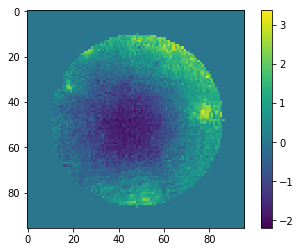

In [108]:
ds=torch.load("../input_tensor/bg_circle.pt")
dataset = list(enumerate(ds))
for i,d in DataLoader(dataset,shuffle=True):
    print(i)
    plt.imshow(d.view(96,96))
    plt.colorbar()
    plt.show()
    break

In [120]:
train_ds = torch.randn(50)
train_ds=train_ds.to(torch.float32)
train_ds = torch.reshape(train_ds,(-1,5))
print(train_ds)
test_ds = list()
for i in range(len(train_ds)):
    test_ds.append(1*train_ds[i,0]+2*train_ds[i,1]+3*train_ds[i,2]+4*train_ds[i,3]+5*train_ds[i,4])  
test_ds=torch.tensor(test_ds)
test_ds=test_ds.to(torch.float32)
print(test_ds)

tensor([[-1.5147,  0.9126,  0.0621, -0.6264, -0.5818],
        [-0.7328, -0.5383,  0.7231, -1.6166,  0.5088],
        [-1.1049, -0.9645, -0.6609, -1.3073,  1.4023],
        [-1.2416,  2.4206, -1.0281,  1.2861, -0.5644],
        [-1.7368,  0.2240,  0.4917,  0.2649,  0.2720],
        [-0.5068,  0.2249, -0.0730, -0.8664, -0.2632],
        [-0.2617, -1.1233, -1.6484, -0.3377, -0.2808],
        [ 0.9731,  2.3578, -0.3191, -0.5527, -0.6915],
        [-0.9027,  1.4376,  0.0159,  1.9131,  1.0852],
        [ 1.6647, -1.5804,  1.3472, -0.2040, -1.2609]])
tensor([ -4.9177,  -3.5626,  -3.2342,   2.8376,   2.6058,  -5.0572, -10.2084,
         -0.9369,  15.0988,  -4.5749])


In [127]:
class fc(nn.Module):
    def __init__(self):
        super(fc,self).__init__()

        self.fc_layer=nn.Sequential(
            nn.Linear(5,1,bias=True))

    def forward(self,z):
        return self.fc_layer(z)

loss_func = torch.nn.SmoothL1Loss()
fc_layer = fc()
# torch.nn.init.constant_(fc_layer.bias.data,0.0)
optimizer = torch.optim.Adam(fc_layer.parameters())

for epoch in range(1000):
    for i in range(len(train_ds)):
        optimizer.zero_grad()
        losses=loss_func(fc_layer(train_ds[i]),test_ds[i])
        losses.backward()
        optimizer.step()

        print("[Epoch %d/%d] [Batch %d/%d] [loss: %f]" %(epoch, 1000, i, len(train_ds), losses.item()))

h 4/10] [loss: 0.003783]
[Epoch 957/1000] [Batch 5/10] [loss: 0.088067]
[Epoch 957/1000] [Batch 6/10] [loss: 0.076330]
[Epoch 957/1000] [Batch 7/10] [loss: 0.182189]
[Epoch 957/1000] [Batch 8/10] [loss: 2.421947]
[Epoch 957/1000] [Batch 9/10] [loss: 0.103428]
[Epoch 958/1000] [Batch 0/10] [loss: 0.933129]
[Epoch 958/1000] [Batch 1/10] [loss: 0.002292]
[Epoch 958/1000] [Batch 2/10] [loss: 0.363980]
[Epoch 958/1000] [Batch 3/10] [loss: 0.002864]
[Epoch 958/1000] [Batch 4/10] [loss: 0.003685]
[Epoch 958/1000] [Batch 5/10] [loss: 0.087459]
[Epoch 958/1000] [Batch 6/10] [loss: 0.075086]
[Epoch 958/1000] [Batch 7/10] [loss: 0.181600]
[Epoch 958/1000] [Batch 8/10] [loss: 2.413604]
[Epoch 958/1000] [Batch 9/10] [loss: 0.103235]
[Epoch 959/1000] [Batch 0/10] [loss: 0.929898]
[Epoch 959/1000] [Batch 1/10] [loss: 0.002273]
[Epoch 959/1000] [Batch 2/10] [loss: 0.362886]
[Epoch 959/1000] [Batch 3/10] [loss: 0.002863]
[Epoch 959/1000] [Batch 4/10] [loss: 0.003588]
[Epoch 959/1000] [Batch 5/10] [loss

In [136]:
tst_item = torch.tensor([2.,1.,2.,1.,3.])
tst_item = tst_item.to(torch.float32)
output = fc_layer(tst_item)
print(output)

tensor([22.1488], grad_fn=<AddBackward0>)


In [12]:
m = nn.Linear(20,30)
input = torch.randn(10,20)
print(input[0])
output = m(input)
print(output.size())
print(output[0])

tensor([-1.5009,  1.7493, -0.7413,  0.8845,  1.6517, -1.0632, -0.8892, -2.0565,
        -1.1484, -1.3725, -0.4392,  0.2635, -0.3662, -0.9369,  0.5032, -1.0420,
        -0.0353,  0.7995,  0.3796,  0.8090])
torch.Size([10, 30])
tensor([ 0.1528,  0.7420,  1.6231, -0.8135,  0.1678, -0.2744,  0.6019, -0.3157,
        -0.0248, -0.3696, -0.1739, -0.3843, -0.9972,  0.5933, -0.9749,  0.3043,
        -0.2638,  0.4927,  0.2237,  0.8823, -0.2525, -0.1662, -0.4285, -0.6298,
         1.2117,  1.0369, -0.3456,  0.5162,  0.0672, -0.9805],
       grad_fn=<SelectBackward>)


In [40]:
tensor = torch.tensor([1.0,1.0,1.0])
print(tensor)
print(nn.init.normal_(tensor))

tensor([1., 1., 1.])
tensor([ 0.3572, -0.5014,  1.7901])


In [3]:
class d(nn.Module):
    def __init__(self):
        super(d,self).__init__()

        self.l1 = nn.Sequential(
            nn.BatchNorm1d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,128,3,stride=1,padding=1),
            nn.LeakyReLU(0.2,inplace=True)
        )

    def forward(self,z):
        out = self.l1(z)
        return img

In [12]:
def p_1(m):
    classname = m.__class__.__name__
    print(classname)
    if classname.find("Conv2d") != -1:
        print(classname)
    elif classname.find("BatchNorm1d") != -1:
        print(classname)

d1=d()
d1.apply(p_1)
# p_1(d1)

BatchNorm1d
BatchNorm1d
Upsample
Conv2d
Conv2d
LeakyReLU
Sequential
d


d(
  (l1): Sequential(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)

In [4]:
class tst():
    def __init__(self,name):
        print("class init")
        self.__name = name
        print("class name: ",self.__name)

name = "name"
t1 = tst(name)

class init
class name:  name


In [5]:
classname = t1.__class__.__name__
print("classname:",classname)
print("type:",type(classname))

classname: tst
type: <class 'str'>
